# Convolutional Neural Network(CNN)

可应用于图像分类，目标检测，图像分割，人脸识别与验证，图像生成与风格迁移，视频分析，图像超分辨率、去噪……在CV领域用处颇广

torchvision 是 PyTorch 官方提供的CV工具库，包含了很多常用的数据集和数据预处理工具。  
datasets.MNIST 是其中的数据集类之一，专门用于 MNIST 数据集，用于自动下载和加载经典的 MNIST 手写数字数据集

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as Data
import matplotlib.pyplot as plt

EPOCH = 1
BATCH_SIZE = 50
LR = 0.00015
DOWNLOAD_MNIST = False #是否下载数据集，若本地已经下载过则设为 False

train_data = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)


①root='./data', 数据集的下载和保存路径,MNIST 数据会下载/解压到 ./data 这个文件夹下  
②train=True,选择加载的是训练集还是测试集。train=True：加载训练集（60000 张图片）;train=False：加载测试集（10000 张图片）  
③transform=torchvision.transforms.ToTensor(),把每张图片由 PIL.Image 或 numpy.ndarray 格式转成 PyTorch 用的 tensor 格式，并且像素值缩放到 [0,1] 区间（浮点数）（将图片由RGB压缩为灰白二维）  
④download=True 是否需要下载数据集。如果为 True，则自动下载数据集（当本地没有时）

torch.Size([60000, 28, 28])
torch.Size([60000])


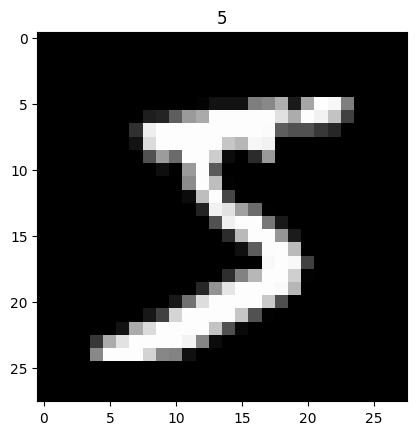

In [ ]:
print(train_data.train_data.size())
# 打印包含所有训练图片的张量各维度的大小   # 60000 张 28x28 的图片
print(train_data.train_labels.size())
# 打印训练图片对应的标签（比如每个图片是哪个数字，0~9）   # 60000 个数字标签
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
#imshow = image show，用于输出第0张图片
#matplotlib 画图需要 numpy 格式，所以要把 PyTorch tensor 转成 numpy 数组
plt.title(f'{train_data.train_labels[0].item()}') # .item() 把张量转成 Python int （不加也可以）
plt.show()

In [ ]:
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [ ]:
test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

#把测试图片变成了 shape 为 [10000, 1, 28, 28]、像素值在 0~1 之间(归一化处理)的 float 格式
test_x = torch.unsqueeze(test_data.data, dim=1).float() / 255.0
#这行代码把测试集前 2000 个图片的标签提取出来
test_y = test_data.test_labels[:1000]#[:2000]：只取前 2000 个标签

d:\deeplearning NN\.venv\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


训练数据(traindata)  
用于训练模型，即让模型“学习”数据中的规律  
测试数据(testdata)  
用于评估模型的泛化能力，即测试模型在未见过的数据上的表现

In [ ]:
#建立CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #第一层卷积层
        self.conv1 = nn.Sequential(         #这一层图片的维度为（1，28，28）（长宽高）
            nn.Conv2d(
                in_channels=1, #输入的图片的高度/通道数，灰度图就是1，彩色图就是3(r、g、b)
                out_channels=16, #卷积核的个数，即输出的通道数
                #就是有k个filter/kernel/卷积核在同一位置提取图片的特征，就把这k个特征叠起来（层数变为k）作为下一层的输入
                kernel_size=5, #卷积核的大小是5x5（单位：像素点）
                stride=1, #卷积核每次移动的步长，单位是像素点
                padding=2 #边缘处理：在图片的边缘补0，补2圈——>为了让输出的图片的长和宽保持不变
            ),
            nn.ReLU(),
            nn.MaxPool2d(2)#新的卷积核尺寸为2x2   #这一步之后图片的长宽发生改变
         )
        self.conv2 = nn.Sequential(         #(16，14，14)
            nn.Conv2d(16,32,5,1,2),         #(32，14，14)
            nn.ReLU(),
            nn.MaxPool2d(2)                 #(32，7，7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)#将三维的数据展平为一维，方便进行分类
        #10是out_features = 10，就是分类的类别数（比如MNIST手写数字识别有10个类别：0~9）
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)           #维度是(batch，32，7，7)
        x = x.view(x.size(0), -1)   #（batch，32*7*7） -1的作用即是把后三个三维展平为一维
        #view()用于重塑形状  #x.size(0)即取了x的shape的第一个特征量
        output = self.out(x)
        return output

每层卷积层包含以下的组件：  
nn.Conv2d(...)：二维卷积层，对输入图片做卷积操作，自动提取局部特征（比如边缘、纹理等）  
nn.ReLU()：AF，为卷积输出增加非线性，提升模型表达能力  
nn.MaxPool2d(2)：二维最大池化层，池化窗口大小为2。对特征图做降采样，减少数据量、参数量，增强特征的空间不变性。效果：每2x2区域取最大值，缩小特征图尺寸（比如从28x28变成14x14）

卷积：滑动遍历整张图片，变成若干张特征图（如16张）。   
激活：将特征图做非线性变换。  
池化：在卷积的基础上，筛选出重要信息。特征图尺寸减半，变成14×14，更精炼。

***每次卷积后的输出***（改变高度）：out_channels=16，意为16个卷积核同时处理了一块区域，叠加后得到了一个长和宽更小的，但是更厚（高）的patch作为输出  
***边缘处理的计算***：如果stride = 1，那么pedding = (kernal_size - 1)/2,这是为了保证输出图片的*长和宽*和原来*保持不变*  
***卷积出的特征图的拼接***：肯定会有重叠，中心位置对齐即可  
***池化层***（改变长和宽）：用一个比卷积层更小的filter遍历卷积层输出的特征图，挑选这个filter区域中的最大值作为新的像素的值（这只是MaxPool2d的做法），把这个filter覆盖的区域合并为一个像素块并把那个最大值作为其像素值

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

#training & testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        output = cnn(x)               # cnn output
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = cnn(test_x[:1000])            # 1000张测试图片
            pred_y = torch.max(test_output, 1)[1].data.squeeze()#torch.max(test_output, 1)[1]：取每行最大值的索引作为预测类别
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3250 | test accuracy: 0.04
Epoch:  0 | train loss: 2.1443 | test accuracy: 0.32
Epoch:  0 | train loss: 1.6064 | test accuracy: 0.73
Epoch:  0 | train loss: 0.8898 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5688 | test accuracy: 0.82
Epoch:  0 | train loss: 0.4071 | test accuracy: 0.84
Epoch:  0 | train loss: 0.6170 | test accuracy: 0.87
Epoch:  0 | train loss: 0.6023 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2572 | test accuracy: 0.88
Epoch:  0 | train loss: 0.0931 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1975 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2938 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3033 | test accuracy: 0.91
Epoch:  0 | train loss: 0.4409 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3750 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1639 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3245 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2831 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1144 | test accuracy

In [ ]:
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
